<p style="text-align:center; font-size: 28px;">CS-C4100 - Digital Health and Human Behavior (2024)</p>

In [ ]:
ID = "102565223"  # Your Student Id

<div class="alert alert-info">

<details open>
    <summary style="font-size: 22px"><b>⚠️ General Tips</b></summary>

* Please review [the general course info](https://mycourses.aalto.fi/course/view.php?id=44883) carefully.
* Feel free to create new code cells. This is a good way to write extra tests you may want to run. Note that all cells are executed during evaluation. 
* **Never** create new cells by menu commands "Edit/Copy Cells" and "Edit/Paste Cells ...". These commands create cells with duplicate ids and make autograding impossible. Use menu commands "Insert/Insert Cell ..." or the button with a plus sign to insert new cells.
* When you write code required to solve an assignment, we highly recommend you to insert the code where it says `# YOUR CODE HERE`.
* If your notebook is broken (e.g. accidentally removed a hidden tests cell, etc.), you can always re-fetch the assignment. To do so, rename the existing folder and fetch the assignment again.
* Do not forget to "Submit" your solution in the "Nbgrader→Assignment List" page after finishing your work. 
* To better understand how doing assignments in JupyterLab works, please refer to the [documentation](https://scicomp.aalto.fi/aalto/jupyterhub/nbgrader-jupyterlab/).

</details>
</div>

---


# Assignment 4.2: Digital Phenotyping (Part 2)

In the previous section of this assignment, we delved into data preprocessing and exploratory analysis within the context of Digital Phenotyping, employing supervised methods. In this notebook, we will focus on unsupervised approaches and statistical tests. The objective is to derive insights from the relationships between wearable metrics and the demographic and metabolic disorder phenotypes of subjects [[1]](#References).

This segment begins with data preprocessing, followed by clustering techniques, and concludes with statistical testing to analyze and verify the findings.

<div class="alert alert-info">

### 📚 Learning outcomes
Upon completing this segment, you will be able to: 

1. Familiarize yourself with cluster quality measuring using Calinski-Harabasz index and Silhouette score.
2. Learn more about K-Means clustering and apply it to the datasets and visualize the clusters.
3. Validate the significance of the observations using statistical testing.
4. Get to know and perfom the one-way ANOVA.

</div>

---

### Table of Contents

* [1. Introduction](#nb2-section1)
    * [1.1. Import Packages](#nb2-section1_1)
    * [1.2. Load the Data](#nb2-section1_2)
* [2. Clustering](#nb2-section2)
    * [2.1. K-Means](#nb2-section2_1)
    * [2.2. The Proper $k$](#nb2-section2_2)
        * [2.2.1 Silhouette Score](#nb2-section2_2_1)
        * [2.2.2 Calinski-Harabasz Index](#nb2-section2_2_2)
* [3. Statistical Testing](#nb2-section3)
    * [3.1. Clusters vs. Age](#nb2-section3_1)
    * [3.2. Significant or not?](#nb2-section3_2)
* [4. Conclusion](#nb2-section4)
* [References](#References)

---

## 1. Introduction <a class="anchor" id="nb2-section1"></a>


### 1.1. Import Packages <a class="anchor" id="nb2-section1_1"></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import f_oneway

import re
import os

if 'AALTO_JUPYTERHUB' in os.environ:
    # Using jupyter shareddata directory
    DATA = '/coursedata/pa4/'
else:
    DATA = '../../data/pa4/'

### 1.2. Load the Data <a class="anchor" id="nb2-section1_2"></a>

In the previous notebook, you familiarized yourself with the data from 233 volunteers who participated in a study on their wearable metrics and cardiovascular phenotypes. In this section, we use their high resolution activity data collected from their tracking wristbands.

Run the cell below to view the dataset.

In [5]:
profiles = pd.read_csv(os.path.join(DATA, "Activity_Profiles.csv"))
profiles.head()

,Gender,Age,V1,V2,V3,V4,V5,V6,V7,V8,...,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96
0,M,65,0.0,0.0,3.120000,4.140000,4.300000,3.920000,3.660,3.400000,...,73.600000,73.880000,74.020000,71.820,68.020000,58.900000,45.320000,30.560000,0.0,0.0
1,M,48,0.0,0.0,2.513333,3.106667,4.120000,3.580000,4.480,4.346667,...,47.360000,62.466667,73.333333,84.700,94.973333,99.306667,80.293333,61.573333,0.0,0.0
2,F,51,0.0,0.0,1.888000,2.048000,2.432000,1.720000,2.192,3.008000,...,52.904000,44.240000,35.800000,31.128,28.632000,29.160000,25.208000,21.200000,0.0,0.0
3,F,41,0.0,0.0,2.453333,3.200000,3.533333,2.786667,2.040,1.293333,...,87.266667,92.373333,87.386667,78.840,71.266667,55.053333,35.066667,21.280000,0.0,0.0
4,M,50,0.0,0.0,0.272000,0.376000,0.480000,0.672000,0.800,0.928000,...,115.208000,94.296000,76.664000,61.344,44.040000,28.968000,18.496000,10.664000,0.0,0.0


This [already preprocessed] dataset contains two columns for *Gender* and *Age*, followed by 96 columns ($\{V_1, \cdots, V_{96}\}$), which indicate step counts in 15min intervals [smoothed by rolling mean] over their participation days for each subject. These values are the profiles which we will explore further in this notebook.

---

## 2. Clustering <a class="anchor" id="nb2-section2"></a>

[Clustering](https://www.geeksforgeeks.org/clustering-in-machine-learning/) is a type of unsupervised learning often used in pattern recognition that involves grouping data points into clusters based on their similarities.

In this section, we form clusters based on the profiles and try to observe possible patterns within the phenotypes or demographic characteristics.

### 2.1. K-Means <a class="anchor" id="nb2-section2_1"></a>

[K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans) is one of the simplest and most popular clustering algorithms. The algorithm aims to partition the observations into $k$ clusters, in which each observation belongs to the cluster with the nearest mean, minimizing the distance within clusters while maximizing the distance between clusters.

<div class="alert alert-warning">

#### 📝 **Task 1**
In this task, you are requried to implement a function that receives data (the **V*** columns in the dataframe) as well as $k$, and returns the cluster labels.

- Fit K-Means:
    - random_state = $42$
    - max_iter = $10^5$
    - n_init = $100$

</div>

<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

- [K-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans)
    
</details>
</div>

In [6]:
def k_means(X, k):
    """
    Perform k-means clustering on the given data.

    Parameters
    ----------
    X : ndarray
        The data to be clustered.
    k : int
        The number of clusters.

    Returns
    -------
    clusters : ndarray
        The cluster labels.
    """
    
    # 1. Perform clustering
    # kmeans = ...
    # clusters = ...
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=10^5, n_init=100)
    kmeans.fit(X)
    clusters = kmeans.labels_
    
    return clusters

In [7]:
# Sanity checks. Do not modify.
profiles_test = np.random.random(size=(6, 10))
clusters_test = k_means(profiles_test, k=4)
assert clusters_test.shape == (6,), "Wrong shape"
assert 0 <= clusters_test.min() <= clusters_test.max() <= 3, "Wrong cluster labels"

In [8]:
# Hidden Tests.

### 2.2. The proper *k* <a class="anchor" id="nb2-section2_2"></a>

The choice for the appropriate number of clusters, *k*, is crucial in k-means clustering, as it directly influences the effectiveness of the model in capturing the underlying structure of the data. There are various methods for evaluating clustering performance. Here, we discuss the Calinski-Harabasz Index and the Silhouette Score.

#### 2.2.1. Silhouette Score <a class="anchor" id="nb2-section2_2_1"></a>

The **Silhouette Score** is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster compared to other clusters, providing a way to assess the compactness and separation of the formed clusters. 

The silhouette score ranges from -1 to 1, with higher values indicating well-separated clusters. Scores near 0 suggest overlap between clusters, while negative scores indicate possible misclassification. Using the function you just implemented, we will determine the optimal number of clusters by comparing scores across different values of $k$, guiding the selection of the most appropriate clustering configuration.

#### 2.2.2. Calinski-Harabasz Index <a class="anchor" id="nb2-section2_2_2"></a>
The **Calinski-Harabasz Index** assesses the compactness of clusters relative to the separation between them. A higher score indicates well-defined and distinct clusters, making this index useful for comparing different values of $k$ and choosing the one that best balances *within-cluster* compactness and *between-cluster* separation.

<div class="alert alert-warning">

#### 📝 **Task 2**
1. Normalize the profiles so that **each row** has a mean of 0 and a standard deviation of 1.
    - remember to exclude the first two columns.
    - Store the results in `profiles_scaled`.
2. Try the values in the given range and plot their corresponding silhouette scores and Calinski-Harabasz indices to see which number of clusters yields the best score. Store the values in `silhouette_scores` and `calsinki_indices`, respectively.
    - $2 \le k \lt 10$

</div>

<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

The following references might come in handy:
- [pandas.DataFrame.sub](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sub.html)
- [pandas.DataFrame.div](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.div.html)
- [sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [sklearn.metrics.calinski_harabasz_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score)
</details>
</div>

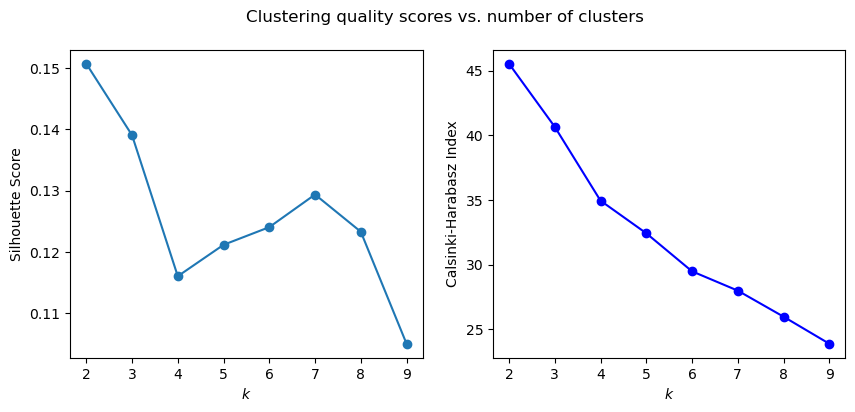

In [54]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

k_range = range(2, 10)
silhouette_scores = []
calsinki_indices = []
## 2.1. Z-score normalization
# profiles_scaled = ...

## 2.2. Iterate over the range of clusters
### 2.2.1 Calculate the scores for each number of clusters
### 2.2.2 Plot the silhouette scores and calsinki-harabasz in two subplots

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

# YOUR CODE HERE
#raise NotImplementedError()
profiles_scaled = profiles.iloc[:,2:].copy()
profiles_scaled = (profiles_scaled.sub(profiles_scaled.mean(axis=1), axis=0)).div(profiles_scaled.std(axis=1), axis=0)


for i in k_range:
    kmeans= KMeans(n_clusters=i, random_state=42)
    kmeans.fit(profiles_scaled)
    
    silhouette = silhouette_score(profiles_scaled, kmeans.labels_)
    calinski_index = calinski_harabasz_score(profiles_scaled, kmeans.labels_)
    
    silhouette_scores.append(silhouette)
    calsinki_indices.append(calinski_index)
    
    
#1st subplot    
    
axes[0].set_xlabel("$k$"), axes[1].set_xlabel("$k$")
axes[0].plot(k_range, silhouette_scores, marker='o')
axes[1].plot(k_range, calsinki_indices, marker='o', color='b')
axes[0].set_ylabel("Silhouette Score")
axes[1].set_ylabel("Calsinki-Harabasz Index")
fig.suptitle("Clustering quality scores vs. number of clusters")

plt.show()

In [55]:
# Sanity Checks. Do not modify.
assert np.isclose(0, profiles_scaled.mean(axis=1).sum()), "Data not centered"
assert np.allclose(np.ones(len(profiles_scaled)), profiles_scaled.std(axis=1)), "Data not scaled"
assert -1 <= np.min(silhouette_scores) <= np.max(silhouette_scores) <= 1, "Wrong silhouette score"

In [56]:
# Hidden Tests.

<div class="alert alert-info">
    <p style="font-size: 18px"><b>🔍 Note</b></p>

- As you see, the trend declines when trying to cluster the values into too many clusters.
- We will continue the analysis using $k=3$.
- Extra: Check out [this page](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics.cluster) for other types of cluster quality metrics.

</div>

In [57]:
df = profiles_scaled.copy()
df['Cluster'] = k_means(df, k=3)

<div class="alert alert-warning">

#### 📝 **Task 3**
1. Map the cluster indices (in the `Cluster` column) using `cluster_colors` and store the resulting series in `row_colors`.
2. Create a new dataframe called `df_sorted`, in which the values are sorted by cluster indices. Then, drop the `Cluster` column.

</div>


<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

These functions may come in handy:
- [pandas.DataFrame.sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)
- [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)
- [pandas.Series.map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

</details>
</div>

In [58]:
cluster_colors = {0: 'darkblue', 1: 'red', 2: 'green'}

# 3.1. Map the cluster assignments to colors
# row_colors = ...

# 3.2. Sort the rows by cluster and drop the cluster column
# df_sorted = ...

# YOUR CODE HERE
#raise NotImplementedError()
row_colors = df['Cluster'].map(cluster_colors)
df_sorted = df.sort_values(by='Cluster').drop(columns=['Cluster'])

In [59]:
# Sanity checks. Do not modify.
assert "Cluster" not in df_sorted.columns, "Cluster column not removed"

In [60]:
# Hidden Tests.

<p id="ref-clustermap" />
And finally, we plot the profiles as a clustermap by running the cell below:

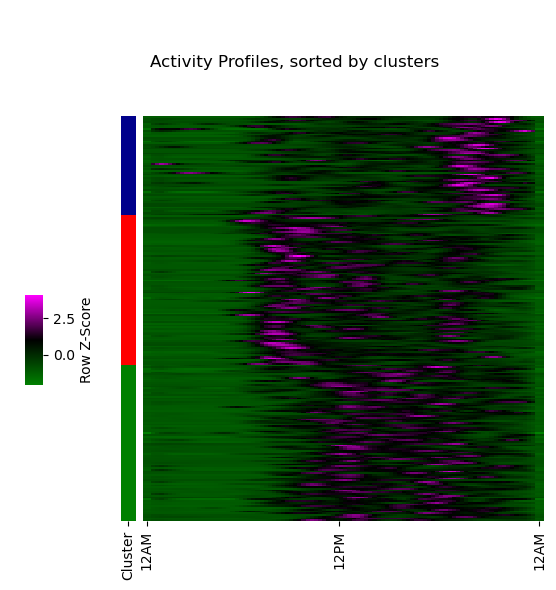

In [61]:
# Define the color maps and plot attributes
cmap = LinearSegmentedColormap.from_list(
    name='GBM_Custom_CMap',
    colors=['green', 'black', 'magenta'],
)

clustermap_kwargs = {
    "cmap": cmap, "linewidths": 0, "linecolor": 'white', "row_cluster": False, "col_cluster": False,
    "row_colors": row_colors, "cbar_pos": (0.05, 0.35, 0.03, 0.15), "cbar_kws": {"label": "Row Z-Score"}
}

# Create the clustermap
cm = sns.clustermap(df_sorted, figsize=(6, 6), **clustermap_kwargs)

plt.suptitle("Activity Profiles, sorted by clusters", y=0.9)
cm.ax_heatmap.set_xticks([1, 47, 95])
cm.ax_heatmap.set_xticklabels(["12AM", "12PM", "12AM"], rotation=90)
cm.ax_heatmap.set_yticks([])

# Show the plot
plt.show()

<div class="alert alert-info">
    <p style="font-size: 18px"><b>🔍 Note</b></p>

- Can you distinguish the profiles in each cluster? What sort of pattern has the clustering captured? Perhaps the following task clarifies the pattern further.

- It appears the physical activity for one cluster is more frequent around 9pm; whereas the average step count peaks at 9am for another cluster. Also, the third cluster indicate a more uniform distribution during the daytime.

- Pay attention to the custom colormap `cmap` and the plot attributes stored in `clustermap_kwargs`, which are defined to improve the quality of the plot. Try to figure out how each of the arguments change the output. For more information, refer to the documentations:
    - [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html)
    - [LinearSegmentedColormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html)

</div>

<div class="alert alert-warning">

#### 📝 **Task 4**
Calculate the average activity profiles for each cluster and plot the lineplots in one figure.
- Use `palette=cluster_colors`.

</div>


<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

- [seaborn.lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html)
- [pandas.DataFrame.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

</details>
</div>

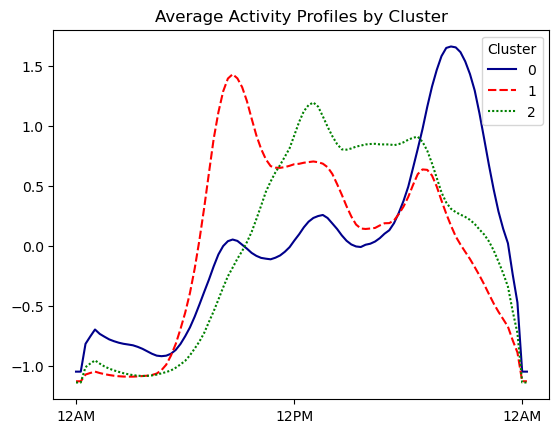

In [62]:
# Plot the average activity profiles for each cluster

# YOUR CODE HERE
#raise NotImplementedError()
avgs = df_sorted.copy()
avgs['Cluster'] = df['Cluster']
clustavg = avgs.groupby('Cluster').mean()

sns.lineplot(data=clustavg.T, palette=cluster_colors)

plt.title("Average Activity Profiles by Cluster")
plt.xticks([0, 46, 94], ["12AM", "12PM", "12AM"])
plt.show()

---

## 3. Statistical Testing <a class="anchor" id="nb2-section3"></a>
In the [first assignment](../pa1/as1.ipynb#Extra-reading:-Statistical-test), hypothesis testing was briefly introduced. It is about time we benefitted from these statistical tests to verify our observations.

<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>🔗 References</b></summary>

- [Assignment 1](../pa1/as1.ipynb#Extra-reading:-Statistical-test)
- [Scribbr | Statistical Tests](https://www.scribbr.com/statistics/statistical-tests/)
- [Scribbr | One-way ANOVA](https://www.scribbr.com/statistics/one-way-anova/)
</details>
</div>

### 3.1. Clusters vs. Age <a class="anchor" id="nb2-section3_1"></a>
Let's create a Box Plot and a Strip Plot (aka Swarm Plot, to show individual data points on top) to observe the *Age* distribution among clusters.


<div class="alert alert-warning">

#### 📝 **Task 5**
1. Create `df_summary` with *only* `Age` and `Cluster` columns.
2. Map the cluster indices to `PM`, `AM`, and `MidDay` accordingly and store in the `Cluster Name` column.
3. Draw the box plot and strip plot over it.
    - For the box plot:
        - color='white' (to view the frame only)
    - For the strip plot:
        - palette=cluster_colors
        - hue='Cluster'
        - jitter=True (to separate points)
</div>


<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

- Use [pandas.Categorical](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html) to retain the order.
- [seaborn.stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html)

</details>
</div>

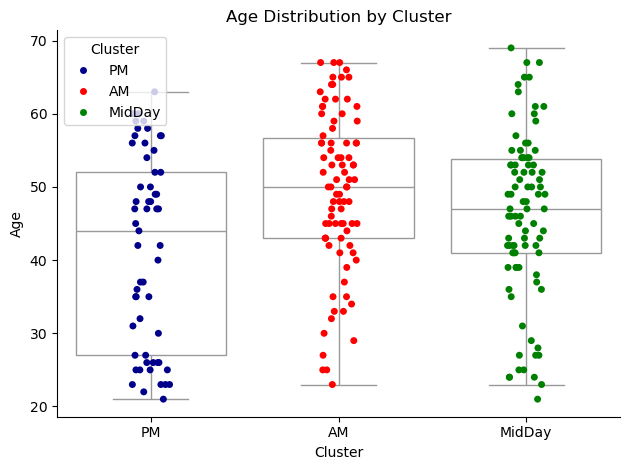

In [63]:
cluster_names = ["PM", "AM", "MidDay"]

# 5.1 Create df_summary
# df_summary = ...
# 5.2 Rename cluster values

# 5.3 Plots
# sns ...

# YOUR CODE HERE
#raise NotImplementedError()
df['Age'] = profiles['Age']
df_summary = df[['Age', 'Cluster']].copy()

df_summary['Cluster Name'] = df_summary['Cluster'].map(lambda x : cluster_names[x])
df_summary['Cluster Name'] = pd.Categorical(df_summary['Cluster Name'], categories=cluster_names, ordered=True)

sns.boxplot(data=df_summary, x='Cluster Name', y='Age', color='white', fliersize=0)
sns.stripplot(data=df_summary, x='Cluster Name', y='Age', palette=cluster_colors, hue='Cluster', jitter=True, size=5)

sns.despine(top=True, right=True)
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Age Distribution by Cluster')

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=cluster_names, title="Cluster")

plt.tight_layout()
plt.show()

In [64]:
# Hidden Tests.

### 3.2. Significant or not? <a class="anchor" id="nb2-section3_2"></a>

As we saw in the [plot](#nb2-section3_1) above, the age distribution seems to vary in each cluster. But we cannot report this without a quantified claim.

In this task, we use the one-way ANOVA (Analysis of Variance). ANOVA is used to compare the means of three or more groups to see if there are any statistically significant differences between them. Click [here](https://www.scribbr.com/statistics/one-way-anova/) for a more in-depth explanation.

<div class="alert alert-warning">

#### 📝 **Task 6**
Perform the one-way ANOVA on the three clusters. Use the implementation from the *Scipy* package.

</div>


<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

- [scipy.stats.f_oneway](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)

</details>
</div>

In [65]:
# 6. Perform the test
# f_stat, p_value = f_oneway(...

# YOUR CODE HERE
#raise NotImplementedError()
f_stat, p_value = f_oneway(df_summary[df_summary['Cluster'] == 0]['Age'], 
                           df_summary[df_summary['Cluster'] == 1]['Age'], 
                           df_summary[df_summary['Cluster'] == 2]['Age'])

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 8.332561398526774
p-value: 0.00032085607159020973


In [66]:
# Hidden Tests.

---

## 4. Conclusion <a class="anchor" id="nb2-section4"></a>

In this segment, we used K-Means clustering, silhouette scoring, and ANOVA testing to demonstrate the possibility of studying the relationship between physical activity and demographic features (e.g. Age).

K-Means clustering revealed distinct groups based on activity patterns and demographic characteristics, with silhouette scores identifying the optimal number of clusters.

In addition, ANOVA testing showed that hidden patterns in wearable metrics (e.g., physical activity) are likely influenced by various factors, including demographic features, highlighting the value of further exploration in this area. 

---

## References

[1] Lim, W. K., Davila, S., Teo, J. X., Yang, C., Pua, C. J., Blöcker, C., ... & Tan, P. (2018). Beyond fitness tracking: the use of consumer-grade wearable data from normal volunteers in cardiovascular and lipidomics research. PLoS biology, 16(2), e2004285. https://doi.org/10.1371/journal.pbio.2004285